# Training an autoencoder for single cell analysis
<img src="imgs/CLAIM_VanillaAE_basic.png" class="center" style="width: 500px;"/>

**Authorship:**
Adam Klie, *01/22/2022*
***
**Description:**
Notebook template for building an training an autoencoder for single cell analysis
***
**Notes:**
 - You need a ipykernel on the Jupyter Lab with PyTorch and Sklearn installed. For instructions on how to quickly get one set up: https://www.notion.so/Autoencoder-Workshop-73d10091ac014f8c966a503e02759b11
 - The default data and model used below are lightweight enough to be trained on a cpu, but if you'd like to train on a larger dataset with more parameters, I would recommend opening a GPU backed notebook. If you are using the `ml_env` kernel described in the above link, you simply need to run the following after logging onto the cluster:
 
 ```bash
 module load cuda10.2
jupyter-submit -p carter-gpu -A carter-gpu -t 05-00:00:00 -c 4 -m 16G -g 1 -I
```
***

### Set-up
Here we load the typical base packages we will utilize throughout the exercise. We will also need to import the PyTorch library and check if we are on a GPU node.

In [11]:
# Classic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
    
%autoreload 2

In [201]:
# PyTorch and GPU check. 
# If you are on a GPU, the function will return True and will tell you which GPU(s) you are using
import torch
print("Using a GPU? {}".format(torch.cuda.is_available()))
if torch.cuda.is_available():
    print("Device number [0-7]: {}".format(torch.cuda.current_device()))
    print("Device count: {}".format(torch.cuda.device_count()))

Using a GPU? True
Device number [0-7]: 0
Device count: 1


In [200]:
# You can use this variable to keep track of how many epochs you've trained a model for
epochs_trained = 0

## Load dataset
Here we load the preprocessed **pbmc3k** dataset. This dataset captures Peripheral Blood Mononuclear Cells (PBMC) freely available from 10X Genomics. There were originally 2,700 single cells that were sequenced on the Illumina NextSeq 500. Here we load in the raw counts for the variable genes in high quality cells. See the `Collect_Datasets_and_Preprocess.ipynb` notebook for more details on the dataset and the preprocessing steps applied.

In [5]:
# Load the raw counts of variable genes. We have less than 2700 cells due to previous filtering
raw_counts = pd.read_csv("data/pbmc3k_raw_var_genes.tsv", index_col=0, sep="\t")
num_genes = raw_counts.shape[0] # rows
num_cells = raw_counts.shape[1] # columns
print("Dataset contains {} genes across {} cells".format(num_genes, num_cells))

Dataset contains 1838 genes across 2638 cells


## Standardize inputs
Here we scale each genes expression to mean 0 and standard deviation 1 across all cells. This will improve convergence properties during training

In [6]:
from sklearn.preprocessing import StandardScaler

In [7]:
# StandardScaler prefers samples x features 
scaler = StandardScaler()
scaler.fit(raw_counts.T)
scaled_counts = scaler.transform(raw_counts.T)
scaled_counts.shape, scaled_counts.mean(axis=0), scaled_counts.std(axis=0)  # Double check scaling was done correctly

((2638, 1838),
 array([-1.02626188e-16,  6.36263428e-16,  2.52517344e-16, ...,
         1.89575421e-16,  2.13459105e-16, -8.80518807e-16]),
 array([1., 1., 1., ..., 1., 1., 1.]))

## Load and initialize a model
Here we initialize a predefined autoencoder architecture. The encoder takes in the same dimenions as variable genes as an input and learns a latent embedding of your specified dimensions (the default is 10). The decoder reconstructs the input via a mirrored architecture to the encoder. This just about the simplest autoencoder architecture you could come up with, so feel free to explore completely different architectures or just change the number of hidden layers, the width per layer, etc.

We initialize the weights using a Kaiming Uniform or He initialzation. Each linear layer is activate with the ReLU function.

In [9]:
# Load model and weight initializer
from utils import init_weights
from autoencoders import VanillaAE

In [12]:
# Instantiate model and move to gpu if available
model = VanillaAE(raw_counts.shape[0])
model.apply(init_weights)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Executing the model on:", device)
model.to(device)

Executing the model on: cuda


VanillaAE(
  (encoder): Sequential(
    (0): Linear(in_features=1838, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1838, bias=True)
  )
)

Let's check what our model looks like, using a handy summary function

In [17]:
from torchinfo import summary

In [18]:
# We will assume a batch size of 256. 
# The summary function expects you to include the expected input size as a parameter along with a batch size
summary(model, input_size=(256, num_genes))

Layer (type:depth-idx)                   Output Shape              Param #
VanillaAE                                --                        --
├─Sequential: 1-1                        [256, 10]                 --
│    └─Linear: 2-1                       [256, 512]                941,568
│    └─ReLU: 2-2                         [256, 512]                --
│    └─Linear: 2-3                       [256, 128]                65,664
│    └─ReLU: 2-4                         [256, 128]                --
│    └─Linear: 2-5                       [256, 10]                 1,290
├─Sequential: 1-2                        [256, 1838]               --
│    └─Linear: 2-6                       [256, 128]                1,408
│    └─ReLU: 2-7                         [256, 128]                --
│    └─Linear: 2-8                       [256, 512]                66,048
│    └─ReLU: 2-9                         [256, 512]                --
│    └─Linear: 2-10                      [256, 1838]              

Next let's test out our autoencoder structure with our initialized parameters. You can use the following code block to check to see if things are being output the way you would expect. By default, the encoded dimension size should be 10 and the size of the decoded dimesion should match the variable genes.

In [199]:
# Grab some seqs and outputs to test out on
indexes = np.random.choice(scaled_counts.shape[0], size=5)
random_cells = torch.from_numpy(scaled_counts[indexes]).float().to(device)
encoded_outputs = model.encoder(random_cells).squeeze(dim=1)
outputs = model(random_cells).squeeze(dim=1)
print("Encoder output dimension: {}\nDecoder output dimension: {}".format(encoded_outputs.shape[1], outputs.shape[1]))

Encoder output dimension: 10
Decoder output dimension: 1838


## Instantiating a dataloader
[DataLoaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) are fundamental PyTorch objects that interface the data you want to train with to the model you want to train. A DataLoader is essentially a Python iterator that can be looped through to pull "batches" of data at time. These "batches" of data are passed to the model during training. 

In [70]:
from torch.utils.data import TensorDataset, DataLoader

In [71]:
# Build a TensorDataset object from the scaled array, note that PyTorch likes Tensors, not numpy arrays
dataset = TensorDataset(torch.from_numpy(scaled_counts))

In [72]:
# Build a simple DataLoaders from the Dataset object
loader = DataLoader(dataset, batch_size=256, shuffle=False)

In [73]:
# Check dims of loaders for correctness (should match n_cells x torch.Size(n_genes))
print("Dimensions of training set: {} x {}".format(len(loader.dataset), loader.dataset[0][0].shape))

Dimensions of training set: 2638 x torch.Size([1838])


## Training set-up

Before we train our model, we need to instantiate a loss function that we are aiming to optimize and an algorithm for conducting that optimization. Here we use **MSE loss** to model the reconstruction of gene expression counts, and optimize using the **adaptive momentum (Adam) algorithmr**. MSE and Adam are popular in deep learning (don't worry, I'm no DanQ), but feel free to play with others or define your own!
 - PyTorch optimizers: https://pytorch.org/docs/stable/optim.html
 - PyTorch loss functions: https://pytorch.org/docs/stable/nn.html#loss-functions

In [23]:
import torch.nn as nn

In [37]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss(reduction='sum')

# Train the model
Here we actually optimize our defined loss function via our autoencoder inputs and reconstructions. We are making use of a training function designed for autoencoders that can be found in the `train.py` file. We will also use the livelossplot package to visualize our loss across training. If all goes well, you should see loss decrease at each epoch (aka iteration through the dataset), something along the lines of:

![loss_plot](imgs/example_loss.png)

In [36]:
from train import train_autoencoder
import time

In [177]:
# Define how many epochs you want to train for
num_epochs = 100

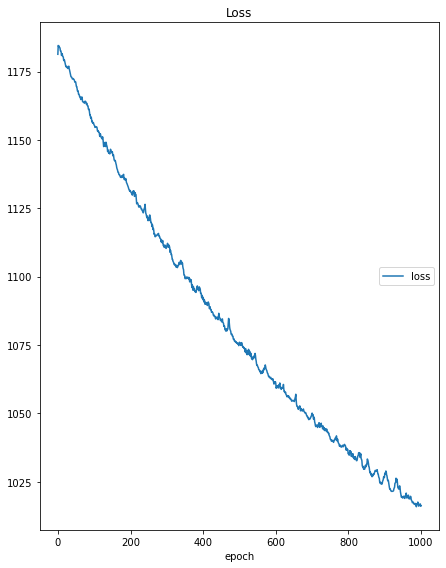

Loss
	loss             	 (min: 1015.890, max: 1184.528, cur: 1016.248)
Trained 1000 epochs in 601.3412 seconds


In [178]:
# Make-it-train!
tic = time.perf_counter()
loss_history, _ = train_autoencoder(model=model, 
                                    dataloader=loader, 
                                    criterion=criterion, 
                                    optimizer=optimizer,
                                    device=device,
                                    num_epoch=num_epochs)
toc = time.perf_counter()
epochs_trained += num_epochs
print(f"Trained {num_epochs:d} epochs in {toc - tic:0.4f} seconds")

In [202]:
import os

In [179]:
# If you are happy with your model, save it's parameters. You can always load it in later for interpretation
# or to do more training
if not os.path.exists("models"):
    os.makedirs("models")
torch.save(model.state_dict(), "models/prelim_model_{}.pt".format(epochs_trained))

## Visualize latent space
We are now ready to investigate that latent space our model has learned. We leave coming up with an awesome new analysis to the user, but we wrote some code for you to generate a two dimensional visualization of your latent space using both PCA and UMAP reduction. We added cell-type labels from the [Seurat guided clustering tutorial](https://satijalab.org/seurat/articles/pbmc3k_tutorial.html). Do you see separation between Seurat's cell-type labels?

In [161]:
from utils import visualize

In [180]:
latent_data = model.encoder(loader.dataset.tensors[0].float().to(device)).detach().cpu().numpy()

In [184]:
cell_ids = [col[0] for col in raw_counts.columns.str.split("-")]

Performing UMAP reduction on latent embedding, may take a minute
Performing PCA on latent embedding


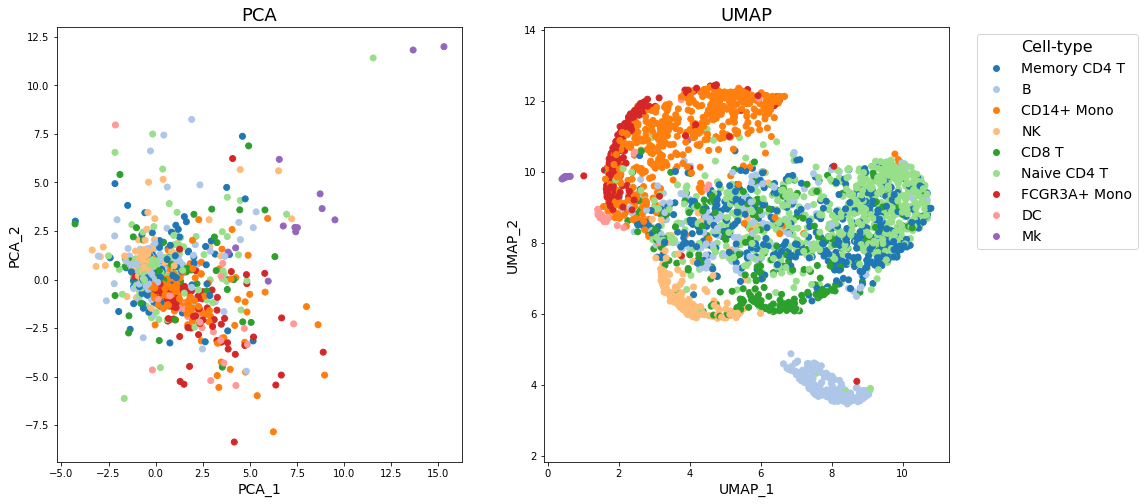

In [190]:
visualize(latent_embedding=latent_data, cellids=cell_ids)

## So how'd you do?

Since we used Scanpy to download the data, we will start by comparing to them. Here's what Scanpy's tutorial outputs on 40 PCs, 10 nearest neighbors and default UMAP settings. They use the same preprocessing strategy we used for this tutorial.

![scanpy_pbm3k](imgs/pbmc3k_100_1.png)

What about Seurat? They have a slightly different pipeline. These were the labels you used for you visualization as well!

![seurat_pbm3k](imgs/pbmc3k_Seurat.png)

# References